# Example for accessing XMM data from XSA

This is a simple example using the [TAP+](https://astroquery.readthedocs.io/en/latest/utils/tap.html) interface to [the XMM archive](http://nxsa.esac.esa.int/nxsa-web/#home).

The result from the `TAP+` query is then used to invoke [the AIO access to the XMM archive](http://nxsa.esac.esa.int/nxsa-web/#aio).

There are two steps:
1. Identify the `observation_id` for a target
2. Download the PPS products for those

At the moment it only works for EPIC instruments. RGS and OM will be added later.

Written Oct 2018 by _Ivan Valtchanov_

In [57]:
import os, io
import requests
import gzip
import tarfile
import warnings

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io.votable import parse_single_table
from astropy.io import fits

from astroquery.utils.tap.core import TapPlus
from astroquery.simbad import Simbad

import aplpy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
def query_xmm_obs(target_name, search_radius=1.0, verbose=True):
    #
    # Query the XMM archive for a target
    # the default search radius is 1 arcmin
    #
    # Will return a table with RA, Dec, observation_id and XMM revolution
    #
    # the NXSA tap plus server
    xmmtap = TapPlus(url="https://nxsa.esac.esa.int/tap-server/tap")
    tables = xmmtap.load_tables(only_names=True)
    #for table in (tables):
    #      print(table.get_qualified_name())
    xmm_table = xmm.load_table('public.v_all_observations')
    #for column in (xmm_table.get_columns()):
    #    print(column.get_name())
    #
    # Invoke Simbad to resolve the name
    #
    target = Simbad.query_object(target_name)
    target_coord = SkyCoord(ra=target[0]["RA"], dec=target[0]["DEC"], unit=(u.hourangle,u.deg), frame='icrs')
    radius = search_radius/60.0 # in degress
    #
    # now construct the ADQL query
    query = 'SELECT top 10 ra,dec,observation_id,revolution ' + \
       'FROM v_public_observations WHERE 1=intersects(observation_fov_scircle,circle(\'ICRS\',{:.5f},{:.5f},{:.1f}))'.format(target_coord.ra.value,target_coord.dec.value,radius)
    #
    if (verbose):
        print ("Will execute the following query: ")
        print (query)
    #
    # run as async query
    #
    job = xmmtap.launch_job_async(query)
    #
    result = job.get_results()
    if (verbose):
        print()
        print("The observations in the NXSA for target {}".format(target_name))
        print (result)
    return result
#

In [77]:
def get_xmm_products(obsid, product="IMAGE",instrument='PN', bands=["1","2","3","5","8"], cache=True, cache_dir=".",verbose=True):
    #
    # Download specific products from the XMM PPS
    #
    instruments = ['PN','M1','M2']
    products = ['IMAGE','EXPMAP','IEVLI']
    if (instrument not in instruments):
        print ("Instrument can be PN, M1 or M2. You entered {}".format(instrument))
        raise Exception
    #
    if (product not in products):
        print ("Product can be IMAGE, EXPMAP or IEVLI. You entered {}".format(product))
        raise Exception
    #
    nxsa_url = 'https://nxsa.esac.esa.int/nxsa-sl/servlet/data-action-aio?obsno={}&level=PPS'.format(obsid)
    #
    pps_tarfile = '{}/{}_PPS_nxsa.tar'.format(cache_dir,obsid)
    if (cache and os.path.isfile(pps_tarfile)):
            print ("Found an already existing PPS tar file: {}. Will reuse it.".format(pps_tarfile))
    else:
        print ("Downloading PPS products for {} from NXSA.".format(obsid))
        r = requests.get(nxsa_url)
        with open(pps_tarfile, "wb") as tmp:
            tmp.write(r.content)
        print ("Saved to {}".format(pps_tarfile))
    #
    output = {}
    with tarfile.open(pps_tarfile,'r') as tar:
        for member in tar.getmembers():
            for j in bands:
                xband = "{}000".format(j)
                if (inst in member.name and product in member.name and xband in member.name ):
                    f=tar.extractfile(member)
                    hdu = fits.open(gzip.open(io.BytesIO(f.read())))
                    header = hdu[0].header
                    output["{}_{}".format(instrument,xband)] = hdu
                    fitsname = os.path.basename(member.name)
                    print ("Saved band {} {} in {}".format(xband,product,fitsname))
                #
            #
        #
    return output

In [65]:
output = query_xmm_obs('Abell 1795')

Created TAP+ (v1.0.1) - Connection:
	Host: nxsa.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Retrieving tables...
Parsing tables...
Done.
Retrieving table 'public.v_all_observations'
Parsing table 'public.v_all_observations'...
Done.
Will execute the following query: 
SELECT top 10 ra,dec,observation_id,revolution FROM v_public_observations WHERE 1=intersects(observation_fov_scircle,circle('ICRS',207.25208,26.58528,0.0))
Query finished.

The observations in the NXSA for target Abell 1795
   ra      dec    observation_id revolution
-------- -------- -------------- ----------
207.2208 26.59222     0097820101        100
207.1458 26.36861     0109070201        567


In [81]:
#
# select the last one
#
ix = 0
obsid = result[ix]["observation_id"].decode()

Once we have the `OBSID` then we can retrieve the products. This uses AIO access.

In [82]:
# set the dir where to store the PPS tar files. 
tmp_dir = os.path.expanduser('~') + '/tmp/XMM_data'
images = get_xmm_products(obsid, product="IMAGE",instrument='PN', bands=["5"], cache=True, cache_dir=tmp_dir,verbose=True)

Saved to /home/ivaltchanov/tmp/XMM_data/0097820101_PPS_nxsa.tar
Saved band 5000 IMAGE in P0097820101PNS005IMAGE_5000.FTZ


In [83]:
images.keys()

dict_keys(['PN_5000'])

In [84]:
images['PN_5000'].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     560   (648, 648)   int32   
  1  GTI00006      1 BinTableHDU     29   21R x 2C   [D, D]   
  2  GTI00106      1 BinTableHDU     29   21R x 2C   [D, D]   
  3  GTI00206      1 BinTableHDU     29   21R x 2C   [D, D]   
  4  GTI00306      1 BinTableHDU     29   21R x 2C   [D, D]   
  5  GTI00406      1 BinTableHDU     29   21R x 2C   [D, D]   
  6  GTI00506      1 BinTableHDU     29   21R x 2C   [D, D]   
  7  GTI00606      1 BinTableHDU     29   20R x 2C   [D, D]   
  8  GTI00706      1 BinTableHDU     29   20R x 2C   [D, D]   
  9  GTI00806      1 BinTableHDU     29   20R x 2C   [D, D]   
 10  GTI00906      1 BinTableHDU     29   20R x 2C   [D, D]   
 11  GTI01006      1 BinTableHDU     29   20R x 2C   [D, D]   
 12  GTI01106      1 BinTableHDU     29   20R x 2C   [D, D]   
 13  GTI01206      1 BinTableHDU     29   20R x 2C   [D, D]   
 14  GTI01306      1 Bi

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


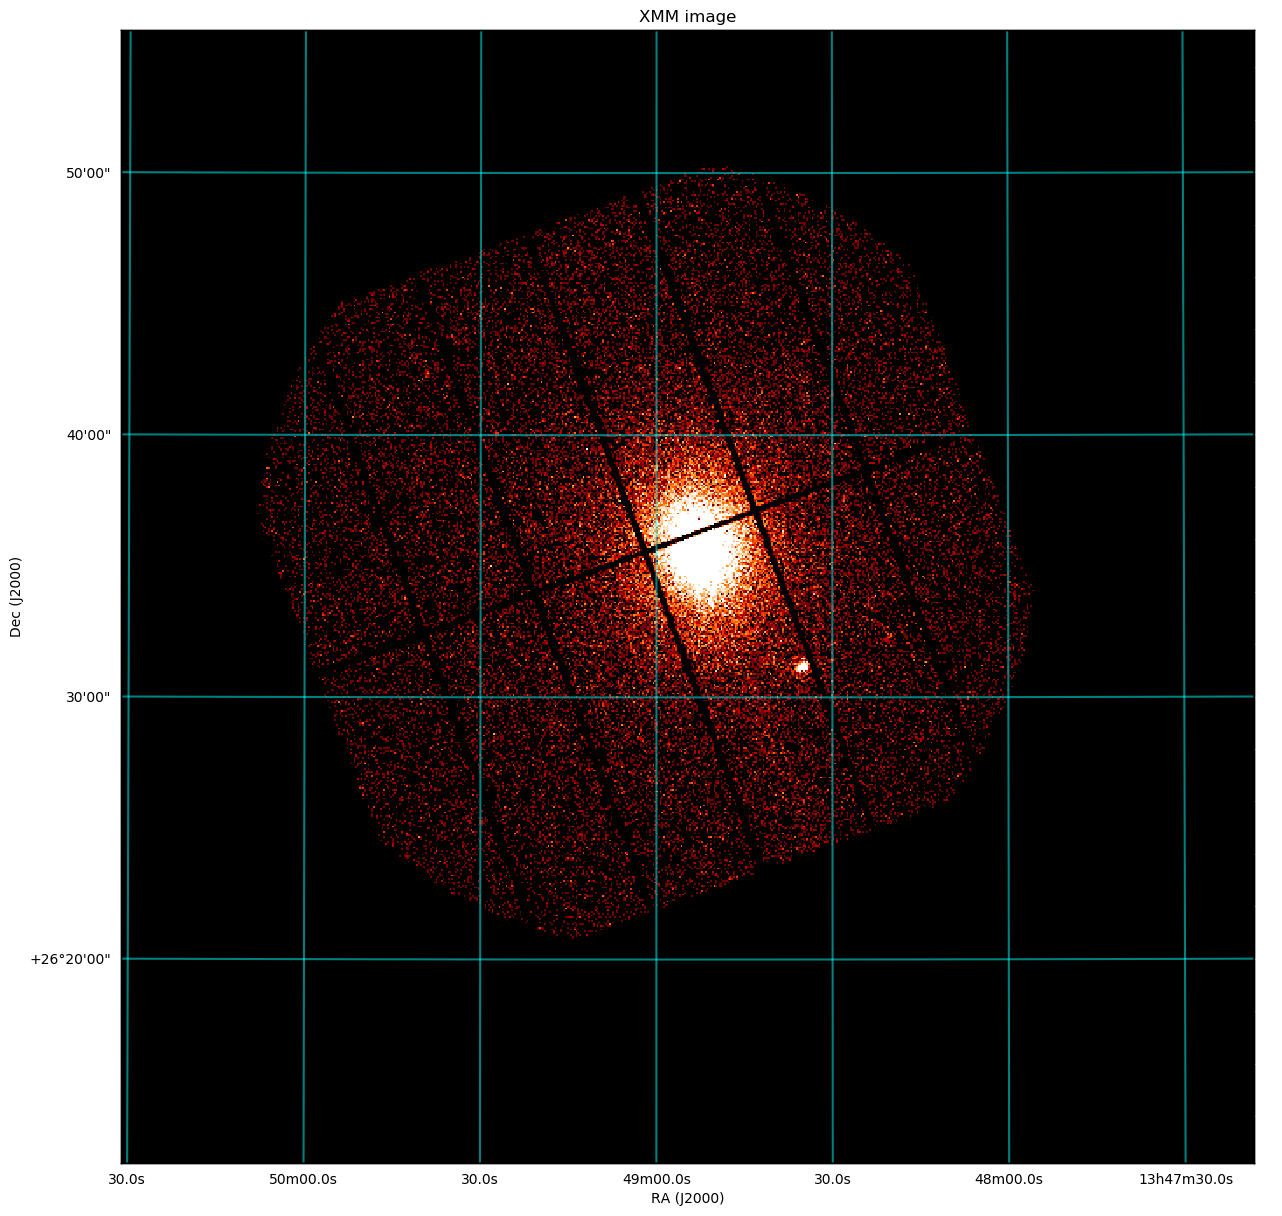

In [85]:
#
# now display it
#
fig = plt.figure(figsize=(15,15),dpi=100)
f1 = aplpy.FITSFigure(images['PN_5000'], figure=fig)
f1.show_colorscale(vmin=1,vmax=10,stretch='log',cmap='gist_heat')
f1.set_title("XMM image".format(band))
f1.tick_labels.set_xformat('hh:mm:ss.s')
f1.tick_labels.set_yformat('dd:mm:ss')
f1.add_grid()
f1.grid.set_color('cyan')
f1.grid.set_alpha(0.5)
